## initial configuration

In [1]:
import sys
from pathlib import Path
from importlib import reload

In [4]:
import platform
import sys
from pathlib import Path
from importlib import reload

os_name = platform.system()
if os_name == 'Darwin':
	gd_path = str(Path.home()/'Library/Mobile Documents/com~apple~CloudDocs/gd')
elif os_name == 'Linux':
	gd_path = str(Path.home()/'gd')
else:
	raise ValueError('You are not on either Darwin or Linux OS')

In [6]:
project_path = gd_path + '/projects'

sys.path.insert(0, project_path + '/ftnmr/scripts')
sys.path.insert(0, project_path + '/projnmr/scripts')
sys.path.insert(0, project_path + '/handson/scripts/part2')
sys.path.insert(0, project_path + '/mods/scripts')

In [8]:
import ftnmr
import projnmr
import handson
import mods
import NN_models

from projnmr import metaboliteGenerator as mg
from string import ascii_letters as al
from functools import partial

In [9]:
import os
# for error "not creating xla devices tf_xla_enable_xla_devices not set"
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#TF_XLA_FLAGS is an environment variable used by TensorFlow's XLA 
#compiler to control its behavior. In this case, setting TF_XLA_FLAGS to 
#--tf_xla_enable_xla_devices enables the XLA compiler to use all available 
# XLA devices, such as GPUs or TPUs, for faster execution of TF.

# for error "Successfully opened dynamic library libcudart.so.10.1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [10]:
import inspect
import random
import psutil
import gc

from functools import partial
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

import tensorflow as tf
from tensorflow import keras

In [11]:
# similar to os.environ['TF_XLA_FLAGS'], but preferred way to enable XLA
tf.config.optimizer.set_jit(True) 

tf.__version__ # TF version

'2.11.1'

In [12]:
devices = tf.config.get_visible_devices()
for dev in devices:
    print(dev.name)

/physical_device:CPU:0
/physical_device:XLA_CPU:0
/physical_device:GPU:0
/physical_device:XLA_GPU:0


In [13]:
tf.test.is_built_with_cuda()

True

In [14]:
import pynvml
pynvml.nvmlInit()

gpus = pynvml.nvmlDeviceGetCount()
for i in range(gpus):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU {i}: Total memory: {info.total / (1024**2)} MB")
    print(f"       Free memory: {info.free / (1024**2)} MB")

pynvml.nvmlShutdown()

GPU 0: Total memory: 24576.0 MB
       Free memory: 24053.25 MB


In [15]:
# Get the Jupyter Lab process ID
jupyter_pid = !pgrep jupyter-lab
jupyter_pid = int(jupyter_pid[0])

# get memory usage of jupyter lab
process = psutil.Process(jupyter_pid)
memory_info = process.memory_info()
print(f"Jupyter Lab memory usage: {memory_info.rss/(1024**2)}MB")

Jupyter Lab memory usage: 115.94140625MB


## creating dataset (VRAM is not taken up for this)

In [89]:
# use the glob() method to find all HDF5 files in subdirectories of the current directory
# hdf5_files = Path('./').glob('data*/*.hdf5')
hdf5_files = Path.home().glob('baseline/data/data.64MB.no_noise_target/*.hdf5')

# transform PosixPath type into string type
hdf5_files = [str(file) for file in hdf5_files if 'baseline' in str(file)]
random.shuffle(hdf5_files)
num_of_files = len(hdf5_files)
hdf5_files

['/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline16.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline05.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline04.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline06.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline08.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline07.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline14.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline09.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline03.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline18.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline00.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline02.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline13.hdf5',
 '/home/sejinnam/baseline

In [86]:
with h5py.File(hdf5_files[0], 'r') as f:
    num_samples = f['data'].shape[0]
    len_input = f['data'].shape[1]

display(num_samples)
display(len_input)

8192

1024

In [90]:
total_num_samples = len(hdf5_files)*num_samples
total_num_samples

163840

In [135]:
shift_path = str(Path.home() / 'baseline/data/chemical_shift.hdf5')

with h5py.File(shift_path, 'r') as f:
    shift_range = f['shift'][:]

shift_range

array([0.0000000e+00, 1.5625000e-02, 3.1250000e-02, ..., 1.5953125e+01,
       1.5968750e+01, 1.5984375e+01], dtype=float32)

In [136]:
shift_range.dtype

dtype('float32')

In [41]:
sample_chunk = int(total_num_samples/num_of_files)
sample_chunk

8192

In [42]:
train_dataset_num = int(num_of_files*.8)
valid_dataset_num =int(num_of_files*.1)

In [43]:
X_train = np.zeros((sample_chunk*train_dataset_num, len_input))
y_train = np.zeros((sample_chunk*train_dataset_num, len_input))

X_valid = np.zeros((sample_chunk*valid_dataset_num, len_input))
y_valid = np.zeros((sample_chunk*valid_dataset_num, len_input))

X_test = np.zeros((sample_chunk*valid_dataset_num, len_input))
y_test = np.zeros((sample_chunk*valid_dataset_num, len_input))

In [58]:
hdf5_files_train = hdf5_files[:train_dataset_num]
hdf5_files_valid = hdf5_files[train_dataset_num:train_dataset_num+1]
hdf5_files_test = hdf5_files[-1:]

display(hdf5_files_train)
display(hdf5_files_valid)
hdf5_files_test

['/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline16.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline11.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline02.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline15.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline19.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline05.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline01.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline03.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline07.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline14.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline00.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline04.hdf5',
 '/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline12.hdf5',
 '/home/sejinnam/baseline

['/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline08.hdf5']

['/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline13.hdf5']

In [45]:
for index, file_path in enumerate(hdf5_files_train):
    start = num_samples*index
    with h5py.File(file_path, 'r') as f:
        X_train[start:start+num_samples] = f['data'][:]
        y_train[start:start+num_samples] = f['target'][:]

X_train.shape

(131072, 1024)

In [49]:
hdf5_files_valid

['/home/sejinnam/baseline/data/data.64MB.no_noise_target/baseline08.hdf5']

In [53]:
for index, file_path in enumerate(hdf5_files_test):
    print(index, file_path)

0 /
1 h
2 o
3 m
4 e
5 /
6 s
7 e
8 j
9 i
10 n
11 n
12 a
13 m
14 /
15 b
16 a
17 s
18 e
19 l
20 i
21 n
22 e
23 /
24 d
25 a
26 t
27 a
28 /
29 d
30 a
31 t
32 a
33 .
34 6
35 4
36 M
37 B
38 .
39 n
40 o
41 _
42 n
43 o
44 i
45 s
46 e
47 _
48 t
49 a
50 r
51 g
52 e
53 t
54 /
55 b
56 a
57 s
58 e
59 l
60 i
61 n
62 e
63 1
64 3
65 .
66 h
67 d
68 f
69 5


In [60]:
for index, file_path in enumerate(hdf5_files_valid):
    start = num_samples*index
    with h5py.File(file_path, 'r') as f:
        X_valid[start:start+num_samples] = f['data'][:]
        y_valid[start:start+num_samples] = f['target'][:]

for index, file_path in enumerate(hdf5_files_test):
    start = num_samples*index
    with h5py.File(file_path, 'r') as f:
        X_test[start:start+num_samples] = f['data'][:]
        y_test[start:start+num_samples] = f['target'][:]

X_test.shape

(16384, 1024)

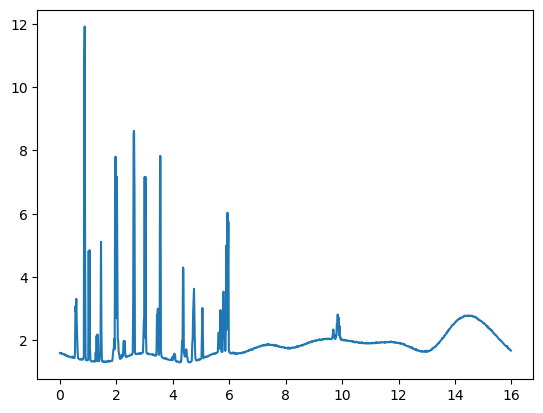

In [61]:
plt.plot(shift_range, X_train[14])
plt.show()

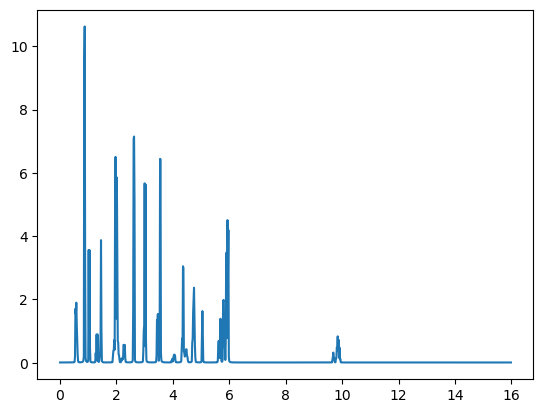

In [62]:
plt.plot(shift_range, y_train[14])
plt.show()

In [63]:
buffer_size = int(X_valid.shape[0]/16)
buffer_size

1024

In [65]:
dataset_train = tf.data.Dataset \
    .from_tensor_slices((X_train, y_train)) \
    .shuffle(buffer_size=buffer_size, seed=42) \
    .batch(32) \
    .prefetch(tf.data.AUTOTUNE)

dataset_valid = tf.data.Dataset \
    .from_tensor_slices((X_valid, y_valid)) \
    .shuffle(buffer_size=buffer_size, seed=42) \
    .batch(32) \
    .prefetch(tf.data.AUTOTUNE)

In [103]:
data_dir = Path.home() / Path('baseline/data/data.64MB.no_noise_target/')
data_dir

PosixPath('/home/sejinnam/baseline/data/data.64MB.no_noise_target')

In [140]:
datasets = ftnmr.load_spec_data(data_dir, numpy_array=False)
datasets

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None))>)

## testing MaxPool1D

In [ ]:
with h5py.File('chemical_shift.hdf5', 'r') as f:
    # Access the dataset
    dataset = f['shift']
    # Load the dataset into memory as a NumPy array
    shift = dataset[:]

shift.shape

with h5py.File('data.2022-03-06~01:42PM/baseline00.hdf5', 'r') as f:
    X = f['data'][:]
    y = f['target'][:]

X.shape

In [ ]:
plt.plot(shift, X[4])
plt.show()

In [ ]:
test_intput = np.expand_dims(X[4], axis=-1)
print(test_intput.shape)

test_intput = np.expand_dims(test_intput, axis=0)
print(test_intput.shape)

input_tensor = tf.convert_to_tensor(test_intput, dtype=tf.float32)
input_tensor

In [ ]:
input_vector = keras.layers.Input([65536, 1])
input_vector

In [ ]:
pool_output = keras.layers.MaxPool1D(16)(input_vector)
pool_output

In [ ]:
test_output = keras.layers.MaxPool1D(32)(input_tensor)
test_output

In [ ]:
reduced_shift = shift[::32]
reduced_shift.shape

In [ ]:
numpy_output = test_output.numpy()
numpy_output.shape

In [ ]:
reshape_output = numpy_output.reshape(2048)
reshape_output.shape

In [ ]:
plt.plot(reduced_shift, reshape_output)
plt.show()

## getting file paths

In [ ]:
# use the glob() method to find all HDF5 files in subdirectories of the current directory
hdf5_files = Path('.').glob('**/*.hdf5')

# transform PosixPath type into string type
hdf5_files = [str(file) for file in hdf5_files if 'baseline' in str(file)]
hdf5_files

In [ ]:
# split the datasets into train, valid, test
files_train = hdf5_files[:-2]
files_valid = hdf5_files[-2:-1]
files_test = hdf5_files[-1:]

files_train

In [ ]:
def data_generator(file_paths, num_samples=512, batch_size=64):
    np.random.shuffle(file_paths)
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            idx = np.random.permutation(num_samples)
            data = f['data'][:][idx]
            target = f['target'][:][idx]
            
            for i in range(0, num_samples, batch_size):
                data = f['data'][i:i+batch_size]
                target = f['target'][i:i+batch_size]
                yield f['data'][i:i+batch_size], f['target'][i:i+batch_size]

In [ ]:
input_shape = (2, 2)
kernel_size = (2, 2)
stride = 1
num_filters = 1

sqm = lambda n: np.expand_dims(np.arange(n**2).reshape(n, n), axis=-1)
lins = lambda n: np.array([np.expand_dims(np.linspace(0, n-1, n), axis=-1)])

In [ ]:
input_tensor = tf.constant([lins(4)], dtype=tf.float32)
matd(input_tensor[0][:, :, 0].numpy())

In [ ]:
input_tensor = tf.constant([sqm(3)], dtype=tf.float32)
matd(input_tensor[0][:, :, 0].numpy())

In [ ]:
kernel_weights = sqm(4)[:1, :, 0]
matd(kernel_weights)
print('kernel_weights')

In [ ]:
?keras.layers.Conv2DTranspose

In [ ]:
output_shape = (None, 3, 3, 1)

# Define the transposed Conv2D layer
tc2_layer = tf.keras.layers.Conv2DTranspose(
    filters=num_filters,
    kernel_size=kernel_weights.shape,
    strides=(1, 2),
    padding='valid',
    kernel_initializer=tf.constant_initializer(kernel_weights),
    #output_padding=
)

# Apply tc2_layer to the input tensor
output_tensor = tc2_layer(input_tensor)
matd(output_tensor[0][:, :, 0].numpy())

## Dynamic Data Generation

In [57]:
spec = ftnmr.spectrometer(shift_maximum=128.0)

mods.print_formatted(spec.nf, spec.nf*spec.df, spec.t[-1], 213)
print()
mods.print_formatted(spec.df, spec.ns, spec.dt, spec.f_s, spec.p, spec.p_l)

065.5k    0006.8    002.4k    0213.0

103.9μ    131.1k    018.3m    0054.5    0019.0    0003.0


In [59]:
ru = np.random.uniform
rr = np.random.randint
moles = {al[26+k]:(mg(), ru(0, 50)) for k in range(0, rr(1, 15))}
moles

{'A': (<ftnmr.molecule at 0x145954205360>, 43.43669613035732),
 'B': (<ftnmr.molecule at 0x145954204af0>, 28.441549051071526),
 'C': (<ftnmr.molecule at 0x145954204b50>, 21.417144283391842),
 'D': (<ftnmr.molecule at 0x145954204d30>, 33.188468923809275),
 'E': (<ftnmr.molecule at 0x145954205960>, 41.56452161435665),
 'F': (<ftnmr.molecule at 0x145954204a30>, 49.27772808625096),
 'G': (<ftnmr.molecule at 0x1459542057e0>, 11.930166396065239)}

In [62]:
spec.artifact(baseline=True)
spec.measure(moles=moles, extra_target=True)

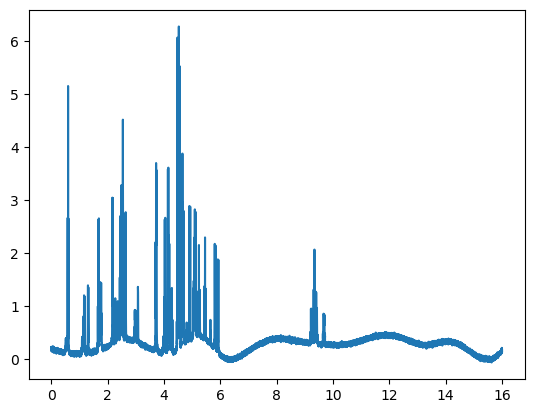

In [64]:
plt.plot(spec.shift, spec.spectra)
plt.show()

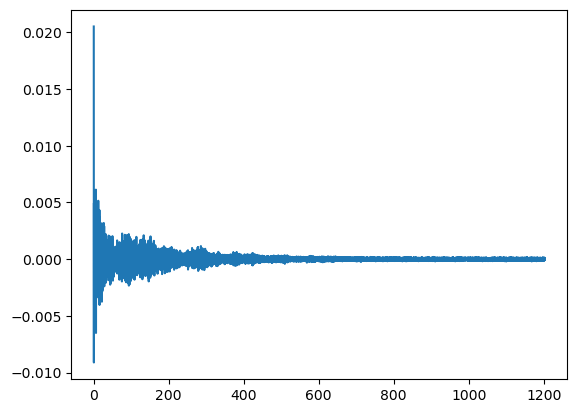

In [65]:
plt.plot(spec.t[:spec.nf], spec.signal.real[:spec.nf])
plt.show()

In [67]:
input_size = 2**10
print(f"input size: {input_size}")
rescale_ratio = int(spec.nf/input_size)
target = np.reshape(spec.target, (input_size, rescale_ratio))
target2 = np.reshape(spec.target2, (input_size, rescale_ratio))
spectra = np.reshape(spec.spectra, (input_size, rescale_ratio))

max_target = np.max(target, axis=1)
mean_target = np.mean(target, axis=1)
max_target2 = np.max(target2, axis=1)
mean_target2 = np.mean(target2, axis=1)
max_spectra = np.max(spectra, axis=1)
mean_spectra = np.mean(spectra, axis=1)

rescaled_shift = spec.shift[::rescale_ratio]

input size: 1024


In [69]:
max_target2

array([0.03871577, 0.0443976 , 0.07105373, ..., 0.05422848, 0.05706055,
       0.04336172], dtype=float32)

In [70]:
max_target

array([0.04645316, 0.04661874, 0.05261057, ..., 0.04181544, 0.053975  ,
       0.06769958], dtype=float32)

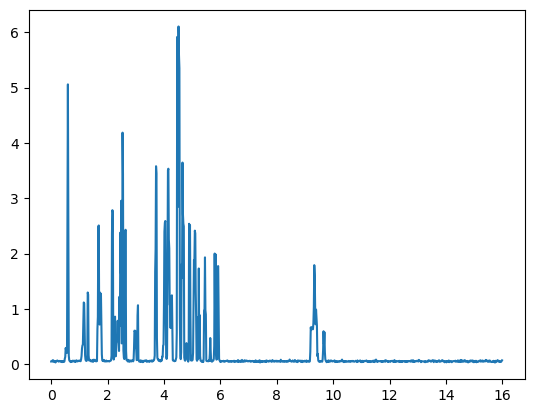

In [72]:
plt.plot(rescaled_shift, max_target)
plt.show()

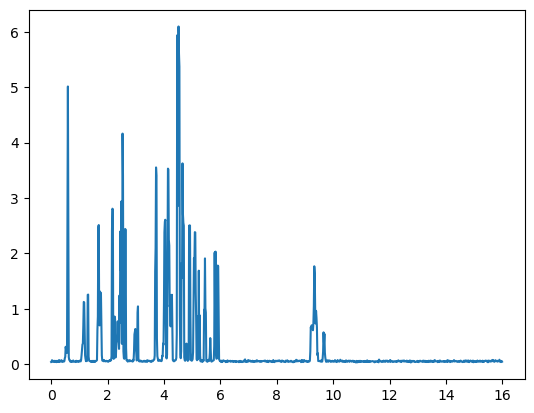

In [71]:
plt.plot(rescaled_shift, max_target2)
plt.show()

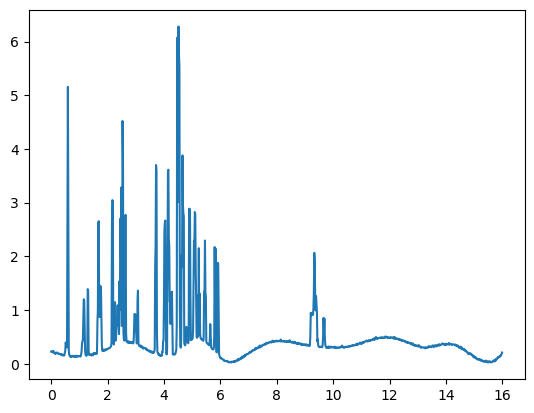

In [73]:
plt.plot(rescaled_shift, max_spectra)
plt.show()

In [79]:
spec()

(array([0.21940625, 0.22487774, 0.20438164, ..., 0.14676362, 0.13862   ,
        0.14151873], dtype=float32),
 array([ 0.03940476,  0.04492171,  0.02447106, ...,  0.00187016,
        -0.00644932, -0.00372657], dtype=float32),
 array([ 0.00957974,  0.03380265,  0.03587672, ...,  0.00833279,
        -0.01300592,  0.00433048], dtype=float32))

## Phase Shift artifact

In [133]:
## initialize spectrometer with random number of molecules
spec = ftnmr.spectrometer(shift_maximum=128.0)
num_of_moles = np.random.randint(1, 15)
input_size = 2**10

# data generator arguments as tf.Tensors that are fed into tf.data.Dataset.from_generator
baseline=False
phase_shift=True
smoothness=False
moles = {al[26+k]:(mg(), np.random.uniform(0, 50)) for k in range(0, num_of_moles)}

# set artifact and measure the signal
spec.artifact(baseline=baseline, phase_shift=phase_shift, smoothness=smoothness)
spec.measure(moles=moles)
input_size = 2**10

In [134]:
max_spectra, max_target, rescaled_shift = ftnmr.max_reduction(spec, input_size)

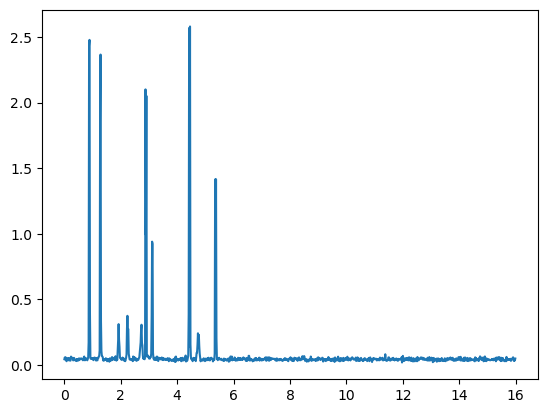

In [135]:
plt.plot(rescaled_shift, max_target)
plt.show()

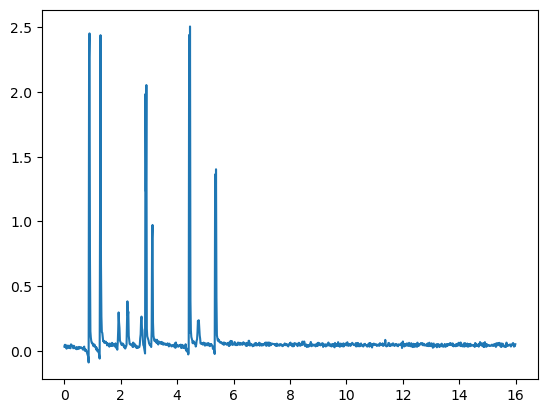

In [136]:
plt.plot(rescaled_shift, max_spectra)
plt.show()

In [120]:
64*20

1280

## Data Generator

In [80]:
# initialize spectrometer with random number of molecules
spec = ftnmr.spectrometer(shift_maximum=128.0)
num_of_moles = np.random.randint(1, 15)

# data generator arguments as tf.Tensors that are fed into tf.data.Dataset.from_generator
baseline=True
phase_shift=False
smoothness=False
moles = {al[26+k]:(mg(), np.random.uniform(0, 50)) for k in range(0, num_of_moles)}

# set artifact and measure the signal
spec.artifact(baseline=baseline, phase_shift=phase_shift, smoothness=smoothness)
spec.measure(moles=moles)

# sample output
output = spec()
output

(array([0.22286393, 0.21535394, 0.22055787, ..., 0.1459843 , 0.13912012,
        0.13936812], dtype=float32),
 array([0.00871326, 0.00871332, 0.00871334, ..., 0.00848973, 0.00848981,
        0.00848982], dtype=float32))

In [56]:
# data generator internal parameters
spec = ftnmr.spectrometer(shift_maximum=128.0)
input_size = 2**10
rescale_ratio = int(spec.nf/input_size)

def data_generator(baseline, phase_shift, smoothness):
    while True:
        # get number of different types of molecules
        rr = np.random.randint
        ru = np.random.uniform
        num_of_moles = rr(1, 15)
        moles = {al[26+k]:(mg(), ru(0, 50)) for k in range(0, num_of_moles)}
    
        # measure the signal with artifact
        spec.artifact(
            baseline=baseline, 
            phase_shift=phase_shift, 
            smoothness=smoothness)
        spec.measure(moles=moles)
    
        # reshape the output for memory management using reshape and max (or mean)
        spectra = np.reshape(spec.spectra, (input_size, rescale_ratio))
        target = np.reshape(spec.target, (input_size, rescale_ratio))
        max_spectra = np.max(spectra, axis=1) # max or mean
        max_target = np.max(target, axis=1) # max or mean
    
        yield max_spectra, max_target

In [57]:
# data generator arguments as tf.Tensors that are fed into tf.data.Dataset.from_generator
baseline=True
phase_shift=False
smoothness=False

args = [baseline, phase_shift, smoothness]
args = tuple(tf.constant(x) for x in args)
display(args)

data_gen_output = data_generator(baseline, phase_shift, smoothness)
data_gen_output

(<tf.Tensor: shape=(), dtype=bool, numpy=True>,
 <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 <tf.Tensor: shape=(), dtype=bool, numpy=False>)

<generator object data_generator at 0x154c1c14eb90>

In [73]:
# dataset from generator
size = input_size
batch_size = 8

dataset = tf.data.Dataset.from_generator(
    data_generator,
    args=args,
    output_signature=(
        tf.TensorSpec(shape=(size,), dtype=tf.float32),
        tf.TensorSpec(shape=(size,), dtype=tf.float32)))

dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_generator(
    data_generator,
    args=args,
    output_signature=(
        tf.TensorSpec(shape=(size,), dtype=tf.float32),
        tf.TensorSpec(shape=(size,), dtype=tf.float32)))

validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

display(dataset)

first_output = next(iter(dataset))
first_output

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None))>

(<tf.Tensor: shape=(8, 1024), dtype=float32, numpy=
 array([[45.098835, 45.108315, 45.050026, ..., 45.000366, 44.93574 ,
         44.8526  ],
        [45.473305, 45.439533, 45.429012, ..., 45.154842, 45.08999 ,
         45.028805],
        [45.564228, 45.557816, 45.514633, ..., 45.220005, 45.143497,
         45.077328],
        ...,
        [46.017487, 45.94809 , 45.92479 , ..., 45.571323, 45.512283,
         45.423103],
        [46.264072, 46.23345 , 46.16962 , ..., 45.653385, 45.58164 ,
         45.501972],
        [46.400356, 46.336567, 46.299034, ..., 45.8601  , 45.80394 ,
         45.72599 ]], dtype=float32)>,
 <tf.Tensor: shape=(8, 1024), dtype=float32, numpy=
 array([[0.01058638, 0.01059614, 0.01060649, ..., 0.01027915, 0.01027913,
         0.01027912],
        [0.00131609, 0.00131823, 0.00132052, ..., 0.00126396, 0.00126396,
         0.00126396],
        [0.01311748, 0.0131321 , 0.01314764, ..., 0.01271258, 0.01271256,
         0.01271254],
        ...,
        [0.01516165, 0.0

### from generator to data

In [71]:
def data_from_generator(generator, num_val_power, batch_size_power):
    """
    The generator must return both target and label data
    """
    assert_info = "batch_size_power is greater than num_val_power"
    assert batch_size_power < num_val_power, assert_info

    # number of validation+train dataset and sample data, batch size
    num_val = 2**num_val_power
    num_tra = 8*num_val
    sample_target, sample_label = next(iter(generator))
    batch_size = 2**batch_size_power

    # shapes for output tensors
    train_target_shape = (num_tra, *sample_target.shape)
    train_label_shape = (num_tra, *sample_label.shape)
    valid_target_shape = (num_val, *sample_target.shape)
    valid_label_shape = (num_val, *sample_label.shape)

    # preallocate output tensors
    target_tra = np.zeros(train_target_shape, dtype=sample_target.dtype)
    label_tra = np.zeros(train_label_shape, dtype=sample_label.dtype)
    target_val = np.zeros(valid_target_shape, dtype=sample_target.dtype)
    label_val = np.zeros(valid_label_shape, dtype=sample_label.dtype)

    # target dataset
    for index, data in zip(range(num_tra), generator):
        target_tra[index], label_tra[index] = data
        
    # validation dataset
    for index, data in zip(range(num_val), generator):
        target_val[index], label_val[index] = data

    # obtain tf.data.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, label_tra))
    train_dataset = train_dataset.batch(batch_size)
    valid_dataset = tf.data.Dataset.from_tensor_slices((target_val, label_val))
    valid_dataset = test_dataset.batch(batch_size)

    return train_dataset, valid_dataset

In [66]:
spec = ftnmr.spectrometer(shift_maximum=128.0)

mods.print_formatted(spec.nf, spec.nf*spec.df, spec.t[-1], 213)
print()
mods.print_formatted(spec.df, spec.ns, spec.dt, spec.f_s, spec.p, spec.p_l)

065.5k    0006.8    002.4k    0213.0

103.9μ    131.1k    018.3m    0054.5    0019.0    0003.0


## Testing Model

In [16]:
data_dir = Path.home() / Path('baseline/data/data.918708/')
datasets = ftnmr.load_spec_data(data_dir, batch_size=128, numpy_array=False)
data_shape = next(iter(datasets[0]))[0].shape
display(data_shape)

2024-02-17 03:00:01.268739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22287 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:b1:00.0, compute capability: 8.0


TensorShape([128, 1024])

In [17]:
dataset_train = datasets[0]
dataset_valid = datasets[1]
dataset_test = datasets[2]

### recurrent NN structures in multiple cells

In [65]:
# configuration
input_length = input_size
expand_layer = keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))
GRU_unit = 16
first_filter_num = 128
transpose_layer = keras.layers.Lambda(lambda x: tf.transpose(x, perm=[0, 1, 3, 2]))
second_filter_num = 64

In [ ]:
seq_input = keras.layers.Input(shape=[input_length])
seq_input

In [ ]:
expand_output = expand_layer(seq_input)
expand_output

In [ ]:
#skip
pool_output = keras.layers.MaxPool1D(pool_size)(expand_output)
pool_output

In [ ]:
GRU_output = keras.layers.Bidirectional(
    keras.layers.GRU(GRU_unit, return_sequences=True))(expand_output)
GRU_output

In [ ]:
expand_output2 = expand_layer(GRU_output)
expand_output2

In [ ]:
cnn_layer1 = keras.layers.Conv2D(
    filters=first_filter_num, 
    kernel_size=(1, 2*GRU_unit), 
    activation='elu')
cnn_output1 = cnn_layer1(expand_output2)
cnn_output1

In [ ]:
transpose_output = transpose_layer(cnn_output1)
transpose_output

In [ ]:
cnn_layer2 = keras.layers.Conv2D(
    filters=second_filter_num, 
    kernel_size=(1, first_filter_num),
    activation='selu')
cnn2_output = cnn_layer2(transpose_output)
cnn2_output

In [ ]:
transpose2_output = transpose_layer(cnn2_output)
transpose2_output

In [ ]:
cnn_layer3 = keras.layers.Conv2D(
    filters=1, 
    kernel_size=(1, second_filter_num),
    activation='selu')
cnn3_output = cnn_layer3(transpose2_output)
cnn3_output

In [ ]:
#skip
upscale_output = keras.layers.UpSampling2D(
    size=(pool_size, 1), 
    interpolation='bicubic')(cnn3_output)
upscale_output

In [ ]:
flat_output = keras.layers.Flatten()(cnn3_output)
flat_output

In [ ]:
model_output = keras.layers.Add()([seq_input, flat_output])
model_output

In [51]:
expand_output

<KerasTensor: shape=(None, 512, 1) dtype=float32 (created by layer 'lambda_2')>

### continue...

In [38]:
# configuration
input_length = data_shape[1]
expand_layer = keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))
GRU_unit = 16
first_filter_num = 128
transpose_layer = keras.layers.Lambda(lambda x: tf.transpose(x, perm=[0, 1, 3, 2]))
second_filter_num = 64

# same as above execution of cells, but all the cells are merged
seq_input = keras.layers.Input(shape=[input_length])

expand_output = expand_layer(seq_input)

GRU_output = keras.layers.Bidirectional(
    keras.layers.GRU(GRU_unit, return_sequences=True))(expand_output)

expand_output2 = expand_layer(GRU_output)

cnn_layer1 = keras.layers.Conv2D(
    filters=first_filter_num, 
    kernel_size=(1, 2*GRU_unit), 
    activation='elu') # elu
cnn_output1 = cnn_layer1(expand_output2)

transpose_output = transpose_layer(cnn_output1)

cnn_layer2 = keras.layers.Conv2D(
    filters=second_filter_num, 
    kernel_size=(1, first_filter_num),
    activation='selu') # selu
cnn2_output = cnn_layer2(transpose_output)

transpose2_output = transpose_layer(cnn2_output)

cnn_layer3 = keras.layers.Conv2D(
    filters=1, 
    kernel_size=(1, second_filter_num),
    activation='LeakyReLU') # selu
cnn3_output = cnn_layer3(transpose2_output)

flat_output = keras.layers.Flatten()(cnn3_output)

model_output = keras.layers.Add()([seq_input, flat_output])

### continue...

In [39]:
model = keras.Model(inputs=[seq_input], outputs=[model_output])

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=10,
    min_delta=0,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [41]:
model.compile(
    loss="mse", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.0005),
    metrics=['mse'])

In [42]:
history = model.fit(
    dataset_train,
    validation_data=dataset_valid,
    epochs=128,
    callbacks=[early_stopping])

Epoch 1/128
1024/1024 [==============================] - 62s 58ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 6.8541e-04 - val_mse: 6.8541e-04
Epoch 2/128
1024/1024 [==============================] - 58s 57ms/step - loss: 5.5261e-04 - mse: 5.5261e-04 - val_loss: 4.5902e-04 - val_mse: 4.5902e-04
Epoch 3/128
1024/1024 [==============================] - 59s 58ms/step - loss: 3.8299e-04 - mse: 3.8299e-04 - val_loss: 3.2949e-04 - val_mse: 3.2949e-04
Epoch 4/128
1024/1024 [==============================] - 58s 57ms/step - loss: 2.8933e-04 - mse: 2.8933e-04 - val_loss: 2.8514e-04 - val_mse: 2.8514e-04
Epoch 5/128
1024/1024 [==============================] - 59s 57ms/step - loss: 2.2813e-04 - mse: 2.2813e-04 - val_loss: 2.0707e-04 - val_mse: 2.0707e-04
Epoch 6/128
1024/1024 [==============================] - 59s 57ms/step - loss: 1.8923e-04 - mse: 1.8923e-04 - val_loss: 1.6995e-04 - val_mse: 1.6995e-04
Epoch 7/128
1024/1024 [==============================] - 59s 57ms/step - loss: 1.6262e-04 

In [48]:
history2 = model.fit(
    dataset_train,
    validation_data=dataset_valid,
    epochs=64,
    callbacks=[early_stopping])

Epoch 1/64
1024/1024 [==============================] - 60s 58ms/step - loss: 8.7084e-06 - mse: 8.7084e-06 - val_loss: 8.2441e-06 - val_mse: 8.2441e-06
Epoch 2/64
1024/1024 [==============================] - 59s 57ms/step - loss: 8.5998e-06 - mse: 8.5998e-06 - val_loss: 8.5726e-06 - val_mse: 8.5726e-06
Epoch 3/64
1024/1024 [==============================] - 59s 58ms/step - loss: 8.6595e-06 - mse: 8.6595e-06 - val_loss: 7.8934e-06 - val_mse: 7.8934e-06
Epoch 4/64
1024/1024 [==============================] - 59s 58ms/step - loss: 8.5906e-06 - mse: 8.5906e-06 - val_loss: 7.7789e-06 - val_mse: 7.7789e-06
Epoch 5/64
1024/1024 [==============================] - 59s 58ms/step - loss: 8.5088e-06 - mse: 8.5088e-06 - val_loss: 1.1517e-05 - val_mse: 1.1517e-05
Epoch 6/64
1024/1024 [==============================] - 59s 58ms/step - loss: 8.4502e-06 - mse: 8.4502e-06 - val_loss: 7.7347e-06 - val_mse: 7.7347e-06
Epoch 7/64
1024/1024 [==============================] - 59s 58ms/step - loss: 8.4850e-06

In [49]:
print(history2.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


In [50]:
for key in history2.history.keys():
    with open('baseline2_' + key + '.npy', 'wb') as f:
        np.save(f, np.array(history.history[key]).astype('float32'))

In [27]:
X_test = next(iter(dataset_test))[0].numpy()
y_test = next(iter(dataset_test))[1].numpy()

In [59]:
y_pred = model.predict(X_test)

4/4 [==============================] - 0s 14ms/step


In [29]:
spec = ftnmr.spectrometer(shift_maximum=128.0)
input_size = 2**10
rescale_ratio = int(spec.nf/input_size)
rescaled_shift = spec.shift[::rescale_ratio]

In [71]:
ind = np.random.choice(range(len(y_pred)))
x_t = X_test[ind]
y_true = y_test[ind]
y_p = y_pred[ind]
print(ind)

58


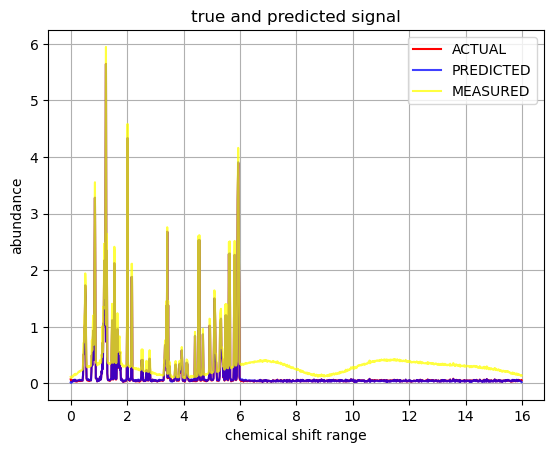

In [72]:
# TRUE plot
plt.plot(rescaled_shift, y_true, label='ACTUAL', color='red')

# PREDICTED plot
plt.plot(rescaled_shift, y_p, label='PREDICTED', color='blue', alpha=0.75)

# MEASURED plot
plt.plot(rescaled_shift, x_t, label='MEASURED', color='yellow', alpha=0.75)

# Set the labels and title
plt.xlabel('chemical shift range')
plt.ylabel('abundance')
plt.title('true and predicted signal')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [52]:
model.save('prototype.feb.16.2024.hdf5')

## loading baseline model

In [15]:
loaded_model_baseline = keras.models.load_model(
    'model_baseline.jan.23.2024.hdf5', 
    compile=False)

In [16]:
data_dir = Path.home() / Path('NMR.data/data.918708/')
datasets = ftnmr.load_spec_data(data_dir, batch_size=128, numpy_array=False)
data_shape = next(iter(datasets[0]))[0].shape
display(data_shape)

dataset_train = datasets[0]
dataset_valid = datasets[1]
dataset_test = datasets[2]

X_test = next(iter(dataset_test))[0].numpy()
y_test = next(iter(dataset_test))[1].numpy()

TensorShape([128, 1024])

In [18]:
y_pred = loaded_model_baseline.predict(X_test)
range_path = Path.home() / Path('NMR.data/chemical_shift.918708.hdf5')
with h5py.File(range_path, 'r') as f:
    chemical_shift = f['shift'][:]

4/4 [==============================] - 0s 17ms/step


In [51]:
ind = np.random.choice(range(len(y_pred)))
x_t = X_test[ind]
y_true = y_test[ind]
y_p = y_pred[ind]
print(ind)

Y = [x_t, y_true, y_p]
Y_names = ['MEASURE', 'ACTUAL', 'PREDICTED'] 
mods.interactive_graph(chemical_shift, Y, Y_names=Y_names)

64


Output()

In [79]:
x = np.linspace(0, 2*np.pi, 101) # x domain
RD = np.random.random # numpy random generator fn
N = 4 # number of plots
Y = [RD()*np.sin(4*RD()*x + 2*np.pi*RD()) for _ in range(N)] # N graphs
Y_names = ['first', 'second', 'third', 'forth'] # names for each y graph
mods.interactive_graph(x, Y, Y_names=Y_names)

Output()

## phase shift model

In [81]:
phase_data_dir = Path.home() / Path('NMR.data/data.918707/')
phase_datasets = ftnmr.load_spec_data(
    phase_data_dir, 
    batch_size=128, 
    numpy_array=False)
data_shape = next(iter(phase_datasets[0]))[0].shape
display(data_shape)

TensorShape([128, 1024])

In [82]:
dataset_train = phase_datasets[0]
dataset_valid = phase_datasets[1]
dataset_test = phase_datasets[2]

In [102]:
input_length = data_shape[1]
GRU_unit = 16
first_filter_num = 128
second_filter_num = 64

In [104]:
model_phase = NN_models.model_NMR(
    input_length, 
    GRU_unit, 
    first_filter_num, 
    second_filter_num)

In [105]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=10,
    min_delta=0,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [106]:
model_phase.compile(
    loss="mse", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.005),
    metrics=['mse'])

In [107]:
history = model_phase.fit(
    dataset_train,
    validation_data=dataset_valid,
    epochs=16,
    callbacks=[early_stopping])

Epoch 1/16
1024/1024 [==============================] - 64s 56ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 2/16
1024/1024 [==============================] - 58s 56ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 8.8941e-04 - val_mse: 8.8941e-04
Epoch 3/16
1024/1024 [==============================] - 59s 57ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 8.5669e-04 - val_mse: 8.5669e-04
Epoch 4/16
1024/1024 [==============================] - 56s 55ms/step - loss: 8.3056e-04 - mse: 8.3056e-04 - val_loss: 7.8516e-04 - val_mse: 7.8516e-04
Epoch 5/16
1024/1024 [==============================] - 59s 58ms/step - loss: 7.8545e-04 - mse: 7.8545e-04 - val_loss: 7.3079e-04 - val_mse: 7.3079e-04
Epoch 6/16
1024/1024 [==============================] - 56s 55ms/step - loss: 7.4980e-04 - mse: 7.4980e-04 - val_loss: 8.1481e-04 - val_mse: 8.1481e-04
Epoch 7/16
1024/1024 [==============================] - 57s 56ms/step - loss: 7.1836e-04 - mse: 7.1836e-04 - val_loss: 6

In [108]:
model_phase.save('model_phase.feb.05.2024.hdf5')

In [109]:
X_test = next(iter(dataset_test))[0].numpy()
y_test = next(iter(dataset_test))[1].numpy()

In [17]:
range_path = Path.home() / Path('NMR.data/chemical_shift.918707.hdf5')
with h5py.File(range_path, 'r') as f:
    chemical_shift = f['shift'][:]

In [22]:
y_pred = model_phase.predict(X_test)

NameError: name 'model_phase' is not defined

In [159]:
ind = np.random.choice(range(len(y_pred)))
x_t = X_test[ind]
y_true = y_test[ind]
y_p = y_pred[ind]
print(ind)

42


In [125]:
ind = np.random.choice(range(len(y_pred)))
x_t = X_test[ind]
y_true = y_test[ind]
y_p = y_pred[ind]
print(ind)

Y = [x_t, y_true, y_p]
Y_names = ['MEASURE', 'ACTUAL', 'PREDICTED'] 
mods.interactive_graph(chemical_shift, Y, Y_names=Y_names)

30


Output()

## phase shift and baseline model

In [13]:
PHB_data_dir = Path.home() / Path('NMR.data/data.918710/')
PHB_datasets = ftnmr.load_spec_data(
    PHB_data_dir, 
    batch_size=128, 
    numpy_array=False)
data_shape = next(iter(PHB_datasets[0]))[0].shape
display(data_shape)

TensorShape([128, 1024])

In [14]:
dataset_train = PHB_datasets[0]
dataset_valid = PHB_datasets[1]
dataset_test = PHB_datasets[2]

In [20]:
X_test = next(iter(dataset_test))[0].numpy()
y_test = next(iter(dataset_test))[1].numpy()

range_path = Path.home() / Path('NMR.data/chemical_shift.918710.hdf5')
with h5py.File(range_path, 'r') as f:
    chemical_shift = f['shift'][:]
    
ind = np.random.choice(range(len(y_test)))
x_t = X_test[ind]
y_true = y_test[ind]
print(ind)

Y = [x_t, y_true]
Y_names = ['MEASURE', 'ACTUAL'] 
mods.interactive_graph(chemical_shift, Y, Y_names=Y_names)

51


Output()

In [21]:
input_length = data_shape[1]
GRU_unit = 32
first_filter_num = 128
second_filter_num = 64

In [59]:
model_PHB = NN_models.model_NMR(
    input_length, 
    GRU_unit, 
    first_filter_num, 
    second_filter_num)

In [60]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=10,
    min_delta=0,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [75]:
model_PHB.compile(
    loss="LogCosh", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.005, clipvalue=1.0),
    metrics=['mse'])

In [76]:
history = model_PHB.fit(
    dataset_train,
    validation_data=dataset_valid,
    epochs=16,
    callbacks=[early_stopping])

Epoch 1/16
1024/1024 [==============================] - 62s 56ms/step - loss: 7.0613e-04 - mse: 0.0015 - val_loss: 6.9278e-04 - val_mse: 0.0014
Epoch 2/16
1024/1024 [==============================] - 61s 60ms/step - loss: 6.0042e-04 - mse: 0.0012 - val_loss: 6.8235e-04 - val_mse: 0.0014
Epoch 3/16
1024/1024 [==============================] - 57s 56ms/step - loss: 5.5091e-04 - mse: 0.0011 - val_loss: 5.7657e-04 - val_mse: 0.0012
Epoch 4/16
1024/1024 [==============================] - 61s 60ms/step - loss: 5.1395e-04 - mse: 0.0011 - val_loss: 6.2274e-04 - val_mse: 0.0013
Epoch 5/16
1024/1024 [==============================] - 65s 63ms/step - loss: 4.8192e-04 - mse: 9.8657e-04 - val_loss: 4.8553e-04 - val_mse: 9.9155e-04
Epoch 6/16
1024/1024 [==============================] - 65s 63ms/step - loss: 4.6039e-04 - mse: 9.4217e-04 - val_loss: 4.2490e-04 - val_mse: 8.6869e-04
Epoch 7/16
1024/1024 [==============================] - 64s 63ms/step - loss: 0.0035 - mse: 0.0085 - val_loss: 8.9297e-0

In [77]:
model_PHB.save('model_PHB.feb.06.2024.hdf5')

In [78]:
y_pred = model_PHB.predict(X_test)

4/4 [==============================] - 1s 23ms/step


In [81]:
ind = np.random.choice(range(len(y_pred)))
x_t = X_test[ind]
y_true = y_test[ind]
y_p = y_pred[ind]
print(ind)

Y = [x_t, y_true, y_p]
Y_names = ['MEASURE', 'ACTUAL', 'PREDICTED'] 
mods.interactive_graph(chemical_shift, Y, Y_names=Y_names)

48


Output()

## Metrics

In [51]:
np.square

<ufunc 'square'>